# Time Series Classification and Clustering Assignment

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Import the Walmart stock price data set (WMT_data.csv).

In [0]:
data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Time%20Series%20Analysis/Time%20Series%20-%20Day%205/WMT_data.csv')
data['date'] = pd.to_datetime(data['date'])
data.columns = ['Date', 'Open', 'High', 'Low', 'Observed', 'Volume', 'Ticker']
data.head()

,Date,Open,High,Low,Observed,Volume,Ticker
0,2013-02-08,71.20,71.64,71.070,71.48,5906823,WMT
1,2013-02-11,71.25,71.51,70.530,71.40,6202534,WMT
2,2013-02-12,71.49,71.66,71.100,71.40,4761910,WMT
3,2013-02-13,71.29,71.70,71.210,71.39,3969807,WMT
4,2013-02-14,71.10,71.23,70.755,70.82,6820952,WMT


### Transform the data to be able to predict minor direction changes in the stock's price, given 180 days of history.

- Remember to calculate daily returns from the observed values (closing price).
- Make the critera for identifying a direction change when the observed values (closing price) cross the 5 day moving average.
- Create a binary column that defaults to 0 unless the criteria is met (then updates to 1).
- Shift the data set so that you have 180 days of history for each record.

In [0]:
data['Returns'] = data['Observed'].pct_change()
data['MA_5'] = data['Observed'].rolling(5).mean()

data['Trend'] = 'None'
data.loc[(data['Observed'] < data['MA_5']), 'Trend'] = 'Negative'
data.loc[(data['Observed'] > data['MA_5']), 'Trend'] = 'Positive'
data['Change'] = data['Trend'].eq(data['Trend'].shift())

data['Binary'] = 0
data.loc[(data['Change']==False) & (data['Trend']!='None'), 'Binary'] = 1

data.dropna(inplace=True)
data.drop(data.index[0], inplace=True)
data.head()

,Date,Open,High,Low,Observed,Volume,Ticker,Returns,MA_5,Trend,Change,Binary
5,2013-02-15,69.54,70.00,68.13,69.30,25687156,WMT,-0.021463,70.862,Negative,True,0
6,2013-02-19,69.19,69.45,68.54,68.76,14683322,WMT,-0.007792,70.334,Negative,True,0
7,2013-02-20,68.72,69.85,68.30,69.21,11973720,WMT,0.006545,69.896,Negative,True,0
8,2013-02-21,70.00,71.47,69.72,70.26,20425983,WMT,0.015171,69.670,Positive,False,1
9,2013-02-22,70.22,70.54,69.89,70.40,9169060,WMT,0.001993,69.586,Positive,True,0


### Train a Logistic Regression classification model on the transformed data.

In [0]:
transformed = data[['Date', 'Returns', 'Binary']]

history = 180
future = 0

shifts = [x + future for x in list(range(1, history + 1))]

for shift in shifts:
    transformed['t-' + str(shift)] = transformed['Returns'].shift(shift)

transformed.dropna(inplace=True)
transformed.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Date,Returns,Binary,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,t-21,t-22,t-23,t-24,t-25,t-26,t-27,t-28,t-29,t-30,t-31,t-32,t-33,t-34,t-35,t-36,t-37,...,t-141,t-142,t-143,t-144,t-145,t-146,t-147,t-148,t-149,t-150,t-151,t-152,t-153,t-154,t-155,t-156,t-157,t-158,t-159,t-160,t-161,t-162,t-163,t-164,t-165,t-166,t-167,t-168,t-169,t-170,t-171,t-172,t-173,t-174,t-175,t-176,t-177,t-178,t-179,t-180
185,2013-11-01,0.004169,1,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,-0.001891,0.001217,...,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463
186,2013-11-04,0.003374,0,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,-0.001891,...,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792
187,2013-11-05,0.001164,0,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,...,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545
188,2013-11-06,0.009558,0,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,...,-0.017195,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171
189,2013-11-07,-0.008316,0,0.009558,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,...,0.014645,-0.017195,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.00066

In [0]:
data['Binary'].value_counts()

0    921
1    333
Name: Binary, dtype: int64

In [0]:
x = transformed.drop(['Date', 'Returns', 'Binary'], axis=1)
y = transformed['Binary']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=False)

model = LogisticRegression(class_weight='balanced')
model.fit(x_train, y_train)
predictions = model.predict(x_test)

### Run a classification report and evaluate the performance of the classifier.

In [0]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.73      0.64      0.68       237
           1       0.27      0.36      0.31        86

    accuracy                           0.57       323
   macro avg       0.50      0.50      0.50       323
weighted avg       0.61      0.57      0.58       323



### Transform the data again to have 10 days of history for clustering.

In [0]:
transformed = data[['Date', 'Returns', 'Binary']]

history = 10
future = 0

shifts = [x + future for x in list(range(1, history + 1))]

for shift in shifts:
    transformed['t-' + str(shift)] = transformed['Returns'].shift(shift)

transformed.dropna(inplace=True)

x = transformed.drop(['Date', 'Returns', 'Binary'], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [0]:
x.head()

,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
15,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463
16,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792
17,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545
18,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171
19,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993


### Train a K Means clustering model on the data. 

Try different values for K and see how the summary changes.

In [0]:
def kmeans(df, clusters=2):
    model = KMeans(n_clusters=clusters, random_state=42)
    clusters = model.fit_predict(df)
    results = df.copy()
    results['Cluster'] = clusters
    
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    
    return results, summary

results, summary = kmeans(x, clusters=5)
summary

,Cluster,Count,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
0,0,265,0.005229,-0.002453,0.000053,0.006116,-0.000041,0.001985,0.009548,-0.001436,-0.002567,-0.000975
1,1,284,0.002357,-0.002161,-0.000689,0.001172,0.006739,0.002073,-0.006748,0.000305,0.006095,-0.004288
2,2,245,-0.002206,0.003518,0.002315,0.002718,-0.004628,-0.007000,-0.001236,0.007485,-0.003377,-0.002589
3,3,205,-0.004647,-0.006778,0.007327,-0.002891,-0.001096,0.000966,-0.000067,-0.000113,0.001251,0.009897
4,4,245,-0.000544,0.008978,-0.005836,-0.006324,-0.000230,0.003685,0.000958,-0.004035,0.000097,0.002268


### Visualize the summary of the clustering results as a heatmap.

In [0]:
def heatmap(df, length=8, width=18, title="", labels=False):
    plt.figure(figsize=(width,length))
    
    if labels == True:
        ax = sns.heatmap(df, annot=True, fmt='.1f', cmap='Reds', linewidths=.01)
    else:
        ax = sns.heatmap(df, cmap="Reds", linewidths=.01)
    
    plt.title(title + "\n", fontsize=16)

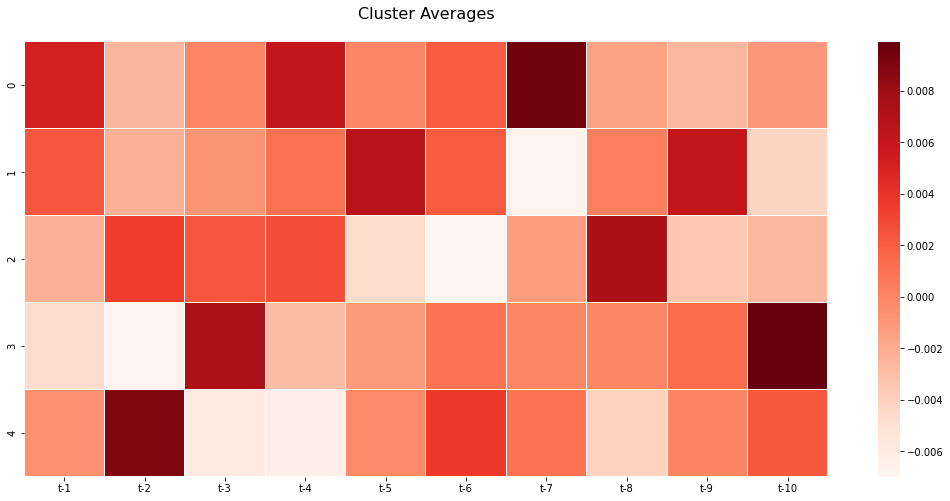

In [0]:
heatmap(summary.drop(['Cluster', 'Count'], axis=1), title='Cluster Averages')